In [1]:
import os 
os.getcwd()

'/home/shiyi/kaggle_hms/notebooks'

In [2]:
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt

train_eeg_dir = Path('../inputs/hms-harmful-brain-activity-classification/train_eegs')
train_spectrogram_dir = Path('../inputs/hms-harmful-brain-activity-classification/train_spectrograms/')

test_dtypes={
    "eeg_label_offset_seconds": "Int64", 
    "spectrogram_label_offset_seconds": "Int64",
    "expert_consensus": "category"
    }

train_df = pd.read_csv('../inputs/hms-harmful-brain-activity-classification/train.csv', dtype=test_dtypes)
display(train_df.head(10))

targets = train_df.columns[-6:] 
print(targets)

submission_df = pd.read_csv('../inputs/hms-harmful-brain-activity-classification/sample_submission.csv')
display(submission_df.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0,353733,0,0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6,353733,1,6,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8,353733,2,8,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18,353733,3,18,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24,353733,4,24,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26,353733,5,26,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30,353733,6,30,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36,353733,7,36,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40,353733,8,40,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0,924234,0,0,1978807404,30539,GPD,0,0,5,0,1,5


Index(['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote',
       'other_vote'],
      dtype='object')


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [3]:
print("Unique eeg_id:", train_df['eeg_id'].nunique())
print("Unique spectrogram_id:", train_df['spectrogram_id'].nunique())
print("Unique patient_id:", train_df['patient_id'].nunique())

Unique eeg_id: 17089
Unique spectrogram_id: 11138
Unique patient_id: 1950


In [4]:
df_agrees = train_df.groupby('eeg_id')['expert_consensus'].nunique().to_frame().reset_index(drop=False)
df_agrees = df_agrees.rename(columns={'expert_consensus': 'n_consensus'})
df_agrees = df_agrees.sort_values('n_consensus', ascending=False)
df_agrees

,eeg_id,n_consensus
5874,1460778765,5
8351,2077161557,4
12367,3088095149,4
11982,2989566754,4
10501,2610655079,4
...,...,...
5837,1451105936,1
5838,1451171468,1
5839,1451703032,1
5840,1452595740,1


In [5]:
def get_non_overlap(df_csv, targets, calc_method='simple'):
    # Reference Discussion:
    # https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

    # train and validate using only 1 crop per eeg_id
    # Simple method:
    # - sum the votes for each label
    # - divide by the total number of votes
    # Weighted method:
    # - calculate the confidence for each label
    # - multiply the confidence by the votes for each label
    # - divide by the sum of the confidence for each label
    # - the confidence is calculated considering:
    #   - the number of votes for the label
    #   - the agreement between the experts

    tgt_list = targets.tolist()
    brain_activity = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
    n_classes = len(brain_activity)

    def calc_confidence(row, n_max, n_classes):
        norm_weight = row['total_experts'] / n_max
        agreement = (row['vote_max'] - row['total_experts']/n_classes) / \
                    (row['total_experts'] - row['total_experts']/n_classes)
        return norm_weight * agreement

    def calc_weighted_votes(grp):

        n_experts_max = grp['total_experts'].max()
        grp['confidence'] = grp.apply(calc_confidence, axis=1, args=(n_experts_max, n_classes))
        grp['confidence_norm'] = grp['confidence'] / grp['confidence'].sum()

        weighted_votes = grp[tgt_list].multiply(grp['confidence_norm'], axis='index').sum()

        return weighted_votes

    agg_dict = {
        'spectrogram_id': 'first',
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'patient_id': 'first',
        'expert_consensus': 'first'
    }
    
    groupby = df_csv.groupby('eeg_id')
    train = groupby.agg(agg_dict)
    train.columns = ['_'.join(col).strip() for col in train.columns.values]
    train.columns = ['spectrogram_id', 'min', 'max', 'patient_id', 'target']

    if calc_method == 'simple':
        vote_sum = groupby[tgt_list].sum()
        class_probs = vote_sum.div(vote_sum.sum(axis=1), axis=0).reset_index(drop=False)

    elif calc_method == 'weighted':
        df_csv['total_experts'] = df_csv[[f"{label}_vote" for label in brain_activity]].sum(axis=1)
        df_csv['vote_max'] = df_csv[[f"{label}_vote" for label in brain_activity]].max(axis=1)
        weighted_votes = df_csv.groupby('eeg_id').apply(calc_weighted_votes, include_groups=False) 
        class_probs = weighted_votes.div(weighted_votes.sum(axis=1), axis=0).reset_index(drop=False)

    train = train.reset_index(drop=False)
    train = train.merge(class_probs, on='eeg_id', how='left')
    
    return train

In [8]:
df_train_simple = get_non_overlap(train_df, targets, calc_method='simple')

df_train_simple.head()

,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,0,16,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,0,38,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,1008,1032,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,908,908,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0,0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000


In [9]:
df_train = get_non_overlap(train_df, targets, calc_method='weighted')

df_train.head()

,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,0,16,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,0,38,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,1008,1032,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,908,908,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0,0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000


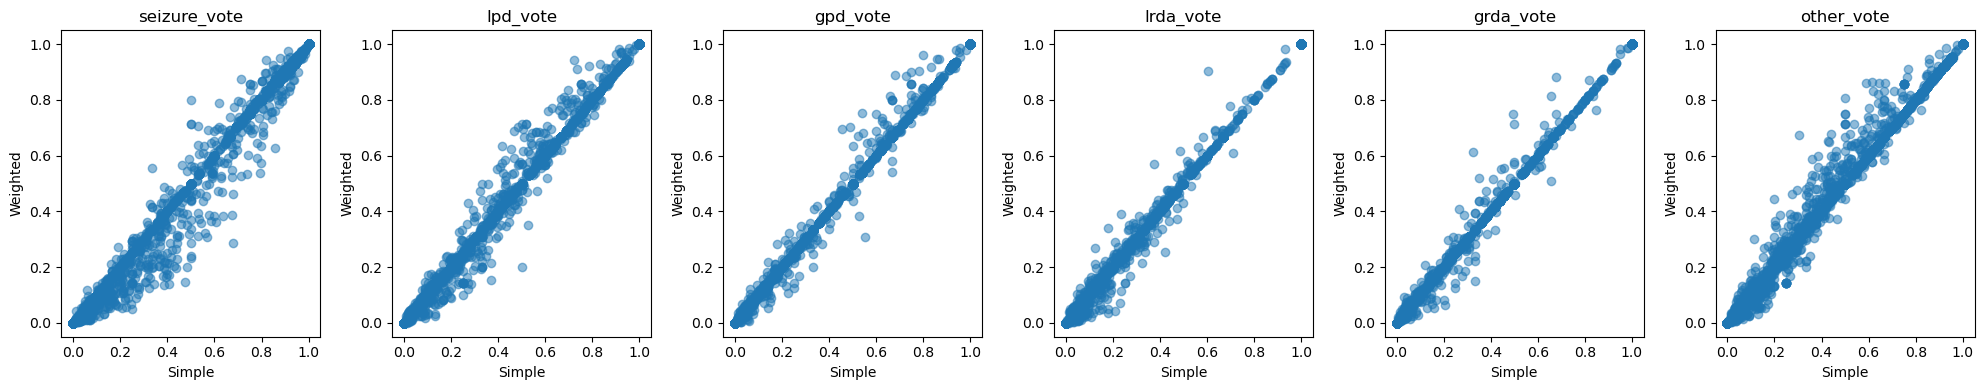

In [13]:
fig, ax = plt.subplots(1, len(targets), figsize=(20, 4))
for i, tgt in enumerate(targets):
    ax[i].scatter(df_train_simple[tgt], df_train[tgt], alpha=0.5)
    ax[i].set_title(tgt)
    ax[i].set_xlabel('Simple')
    ax[i].set_ylabel('Weighted')

fig.tight_layout()
plt.show()

In [12]:
td = train_df.iloc[0:10]

sum_to_one = td[targets].div(td[targets].sum(axis=1), axis=0).sum(axis=1)

(sum_to_one == 1.0).all()

True

In [ ]:
vote_cols = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_df['total_voters'] = train_df[vote_cols].sum(axis=1)

plt.figure(figsize=(10, 6))
plt.hist(train_df['total_voters'], bins=10)
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Voters')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [4]:
eeg_id = 1628180742
eeg_df = pd.read_parquet(train_eeg_dir/f"{eeg_id}.parquet")
print(eeg_df.shape)
eeg_df.head()

(18000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997


In [5]:
spec_id = 789577333
spec_df = pd.read_parquet(train_spectrogram_dir/f"{spec_id}.parquet")
print(spec_df.shape)
spec_df.tail()

(308, 401)


,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
303,607,183.179993,184.210007,241.309998,273.200012,214.869995,292.540009,203.919998,126.650002,158.000000,...,0.31,0.18,0.31,0.21,0.24,0.29,0.29,0.29,0.33,0.34
304,609,127.980003,149.830002,207.550003,248.729996,263.920013,199.929993,191.320007,116.330002,80.309998,...,0.19,0.12,0.11,0.13,0.09,0.13,0.23,0.16,0.21,0.17
305,611,84.040001,125.550003,178.250000,263.269989,300.239990,301.369995,264.720001,179.059998,119.279999,...,0.19,0.20,0.18,0.15,0.16,0.23,0.23,0.32,0.32,0.29
306,613,116.540001,138.429993,218.479996,190.360001,276.760010,218.750000,236.190002,161.919998,120.449997,...,0.31,0.25,0.13,0.20,0.29,0.31,0.30,0.31,0.33,0.31
307,615,109.300003,149.509995,209.550003,262.339996,315.040009,347.220001,298.170013,233.660004,166.020004,...,0.43,0.49,0.42,0.43,0.41,0.33,0.44,0.36,0.41,0.55


In [6]:
def load_eeg_and_spectrogram(eeg_id, spec_id, eeg_offset, spec_offset):

    eeg_df = pd.read_parquet(train_eeg_dir/f"{eeg_id}.parquet")
    start_eeg = eeg_offset * 200
    end_eeg = start_eeg + (200 * 50)

    eeg = eeg_df.iloc[start_eeg:end_eeg,]

    spec_df = pd.read_parquet(train_spectrogram_dir/f"{spec_id}.parquet")
    start_spec = spec_offset
    end_spec = start_spec + 600

    spec = spec_df[(spec_df["time"] <= end_spec) & (spec_df["time"] >= start_spec)]

    return eeg, spec

from scipy.signal import butter, sosfilt

sos = butter(4, [1, 40], btype="bandpass", fs=200, output='sos')

def central_window_eeg(df, window_seconds=10):
    start = df.index[0]
    end = df.index[-1]
    mid = (start + end) / 2
    new_start = int(mid - window_seconds/2 * 200) - start + 1
    new_end = int(mid + window_seconds/2 * 200) - start + 1
    return df.iloc[new_start:new_end]

def plot_eeg(df, bp_filter=True):

    fig, axs = plt.subplots(20, 1, figsize=(15, 10), sharex=True)
    
    for i, ax in enumerate(axs):
        
        if bp_filter:
            ts_signal = sosfilt(sos, df.iloc[:,i])
        else:
            ts_signal = df.iloc[:,i]

        ax.plot(ts_signal, color="black")
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
    
    fig.tight_layout()
    plt.show()

def plot_spec(df):

    fig, axs = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

    prefixes = ['LL', 'RL', 'LP', 'RP']

    for ax, prefix in zip(axs.flatten(), prefixes):
        cols = df.filter(regex=f"^{prefix}_").columns
        ax.imshow(df[cols].T, origin="lower", norm="log", cmap="plasma", interpolation="none")
        ax.set_title(prefix, fontsize=12, fontweight="bold")
        ax.set_yticks(np.arange(0, 101, 25.))
        ax.set_yticklabels([0, 5, 10, 15, 20])
        ax.set_xticks(np.arange(0, 301, 75.))
        ax.set_xticklabels(range(df.iloc[0, 0], df.iloc[-1, 0], (df.iloc[-1, 0]-df.iloc[0, 0])//4))

    for ax in axs[:, 0]:
        ax.set_ylabel("Frequency (Hz)")
    for ax in axs[-1, :]:
        ax.set_xlabel("Time (s)")

    fig.tight_layout()
    plt.show()

In [7]:
choose_row = 2387

eeg_id, spec_id, eeg_offset, spec_offset = train_df.loc[choose_row, ['eeg_id', 'spectrogram_id', 'eeg_label_offset_seconds', 'spectrogram_label_offset_seconds']]

votes = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote" ]

print(f"eeg_id: {eeg_id}, spec_id: {spec_id}, eeg_offset: {eeg_offset}, spec_offset: {spec_offset}")
print(f"patient_id: {train_df.loc[choose_row, 'patient_id']}")
print(f"label_id: {train_df.loc[choose_row, 'label_id']}")
print(f"expert_consensus: {train_df.loc[choose_row, 'expert_consensus']}")
print(f"Votes: ")
for vote in votes:
    print(f"{vote}: {train_df.loc[choose_row, vote]}")


df_eeg, df_spec = load_eeg_and_spectrogram(eeg_id, spec_id, eeg_offset, spec_offset)

eeg_id: 3993339574, spec_id: 34196486, eeg_offset: 18, spec_offset: 18
patient_id: 2808
label_id: 941067940
expert_consensus: GRDA
Votes: 
seizure_vote: 0
lpd_vote: 0
gpd_vote: 0
lrda_vote: 0
grda_vote: 3
other_vote: 0


In [8]:
df_eeg.head(20)

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
3600,-35.439999,62.450001,12.500000,57.240002,46.180000,-6.630000,88.139999,-9406.769531,14.740000,46.369999,70.389999,-28.620001,67.739998,28.790001,36.599998,-30.959999,48.270000,11.350000,53.259998,-185.080002
3601,-323.519989,-223.679993,-135.800003,-90.489998,-296.559998,-175.039993,-212.089996,5907.250000,-254.119995,-180.929993,-158.639999,-315.209991,-281.190002,-138.179993,-151.320007,-245.080002,-191.539993,-99.379997,-181.649994,-222.940002
3602,-384.720001,-319.290009,-387.040009,-373.869995,-357.290009,-129.630005,-269.260010,5718.160156,-306.850006,-262.709991,-257.239990,-344.619995,-262.709991,-316.399994,-277.299988,-306.739990,-183.289993,-262.059998,-256.630005,-162.160004
3603,-51.590000,35.470001,90.519997,24.600000,14.520000,-28.150000,151.850006,-9506.370117,-5.410000,43.799999,63.209999,-63.419998,16.010000,-34.599998,16.750000,-3.800000,88.699997,-6.620000,52.330002,-239.440002
3604,-206.479996,-151.360001,-111.199997,2.130000,-80.870003,-26.719999,-130.210007,100.199997,-160.710007,-100.440002,-77.129997,-201.919998,-145.559998,-86.019997,-79.019997,-156.710007,-115.080002,-88.279999,-101.290001,-252.279999
3605,-434.140015,-279.980011,-405.950012,-322.380005,-403.200012,-245.630005,-300.070007,9375.009766,-355.299988,-292.579987,-290.630005,-401.809998,-352.070007,-244.960007,-285.100006,-364.380005,-288.350006,-260.500000,-303.839996,-216.990005
3606,-165.550003,-22.010000,-30.250000,-136.529999,-81.959999,-49.639999,19.610001,-6031.109863,-84.769997,-24.000000,-8.830000,-138.779999,-65.120003,-82.769997,-27.750000,-53.599998,0.160000,-12.250000,3.470000,-286.040009
3607,-59.939999,28.030001,-67.239998,8.180000,-11.010000,21.799999,-45.470001,-5900.640137,-45.419998,-20.910000,-7.800000,-83.570000,-16.690001,-107.110001,-51.820000,-41.470001,69.879997,-188.250000,-48.570000,-256.149994
3608,-444.750000,-269.440002,-398.399994,-240.199997,-410.420013,-239.669998,-289.049988,9311.740234,-355.880005,-287.600006,-268.640015,-417.329987,-362.950012,-257.559998,-252.779999,-272.739990,-279.660004,-136.429993,-272.730011,-157.139999
3609,-290.190002,-207.479996,-192.759995,-316.170013,-96.260002,-55.220001,-194.179993,-333.790009,-209.630005,-153.979996,-134.460007,-252.179993,-168.740005,-234.250000,-148.369995,-177.610001,-105.459999,-111.709999,-112.169998,-180.880005


In [9]:
df_spec.head(20)

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
9,19,79.309998,110.870003,131.679993,122.040001,96.269997,48.910000,54.570000,47.130001,59.310001,...,0.10,0.08,0.16,0.10,0.17,0.16,0.11,0.13,0.09,0.15
10,21,69.230003,103.989998,133.880005,134.669998,121.260002,99.070000,113.629997,98.709999,98.830002,...,0.29,0.39,0.39,0.27,0.23,0.17,0.11,0.10,0.14,0.12
11,23,53.900002,79.769997,108.739998,105.029999,85.930000,53.750000,79.449997,86.860001,88.150002,...,0.38,0.38,0.34,0.32,0.22,0.12,0.11,0.09,0.07,0.09
12,25,35.169998,42.599998,42.009998,45.660000,33.950001,44.150002,83.589996,65.220001,66.019997,...,0.20,0.16,0.14,0.13,0.11,0.12,0.11,0.08,0.10,0.13
13,27,23.350000,34.290001,46.840000,64.510002,69.160004,63.709999,79.720001,51.669998,45.049999,...,0.08,0.10,0.06,0.10,0.08,0.11,0.13,0.13,0.12,0.15
14,29,49.200001,67.930000,56.430000,95.040001,85.010002,62.630001,74.949997,51.410000,33.340000,...,0.16,0.13,0.18,0.20,0.18,0.18,0.15,0.13,0.15,0.10
15,31,61.480000,80.750000,84.099998,89.320000,80.430000,69.849998,92.830002,46.759998,48.040001,...,0.19,0.17,0.17,0.19,0.17,0.16,0.16,0.13,0.11,0.06
16,33,84.010002,122.709999,146.770004,114.129997,124.269997,101.489998,101.750000,102.959999,92.989998,...,0.15,0.13,0.11,0.12,0.13,0.13,0.11,0.12,0.07,0.06
17,35,125.099998,139.600006,162.789993,170.289993,111.500000,88.589996,68.680000,92.879997,97.260002,...,0.08,0.10,0.05,0.12,0.12,0.12,0.13,0.14,0.09,0.12
18,37,91.160004,170.270004,159.880005,179.979996,209.119995,162.899994,121.050003,112.800003,68.930000,...,0.12,0.11,0.08,0.04,0.06,0.09,0.10,0.10,0.15,0.13


In [10]:
LL_freq = df_spec.filter(regex="^LL_")
LL_freq.head()

,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,...,LL_18.16,LL_18.36,LL_18.55,LL_18.75,LL_18.95,LL_19.14,LL_19.34,LL_19.53,LL_19.73,LL_19.92
9,79.309998,110.870003,131.679993,122.040001,96.269997,48.910000,54.570000,47.130001,59.310001,60.790001,...,1.30,1.00,1.15,1.13,2.22,2.56,2.73,2.39,1.69,1.31
10,69.230003,103.989998,133.880005,134.669998,121.260002,99.070000,113.629997,98.709999,98.830002,82.419998,...,0.65,0.89,0.52,0.79,0.90,0.82,1.15,1.49,1.53,2.09
11,53.900002,79.769997,108.739998,105.029999,85.930000,53.750000,79.449997,86.860001,88.150002,72.349998,...,0.99,1.17,1.39,1.04,1.06,0.92,1.04,1.00,1.72,2.01
12,35.169998,42.599998,42.009998,45.660000,33.950001,44.150002,83.589996,65.220001,66.019997,61.849998,...,1.10,0.97,0.75,0.91,0.59,0.73,0.78,1.44,1.88,1.26
13,23.350000,34.290001,46.840000,64.510002,69.160004,63.709999,79.720001,51.669998,45.049999,40.299999,...,2.16,2.38,2.03,1.43,0.97,1.56,2.53,2.69,2.74,2.10


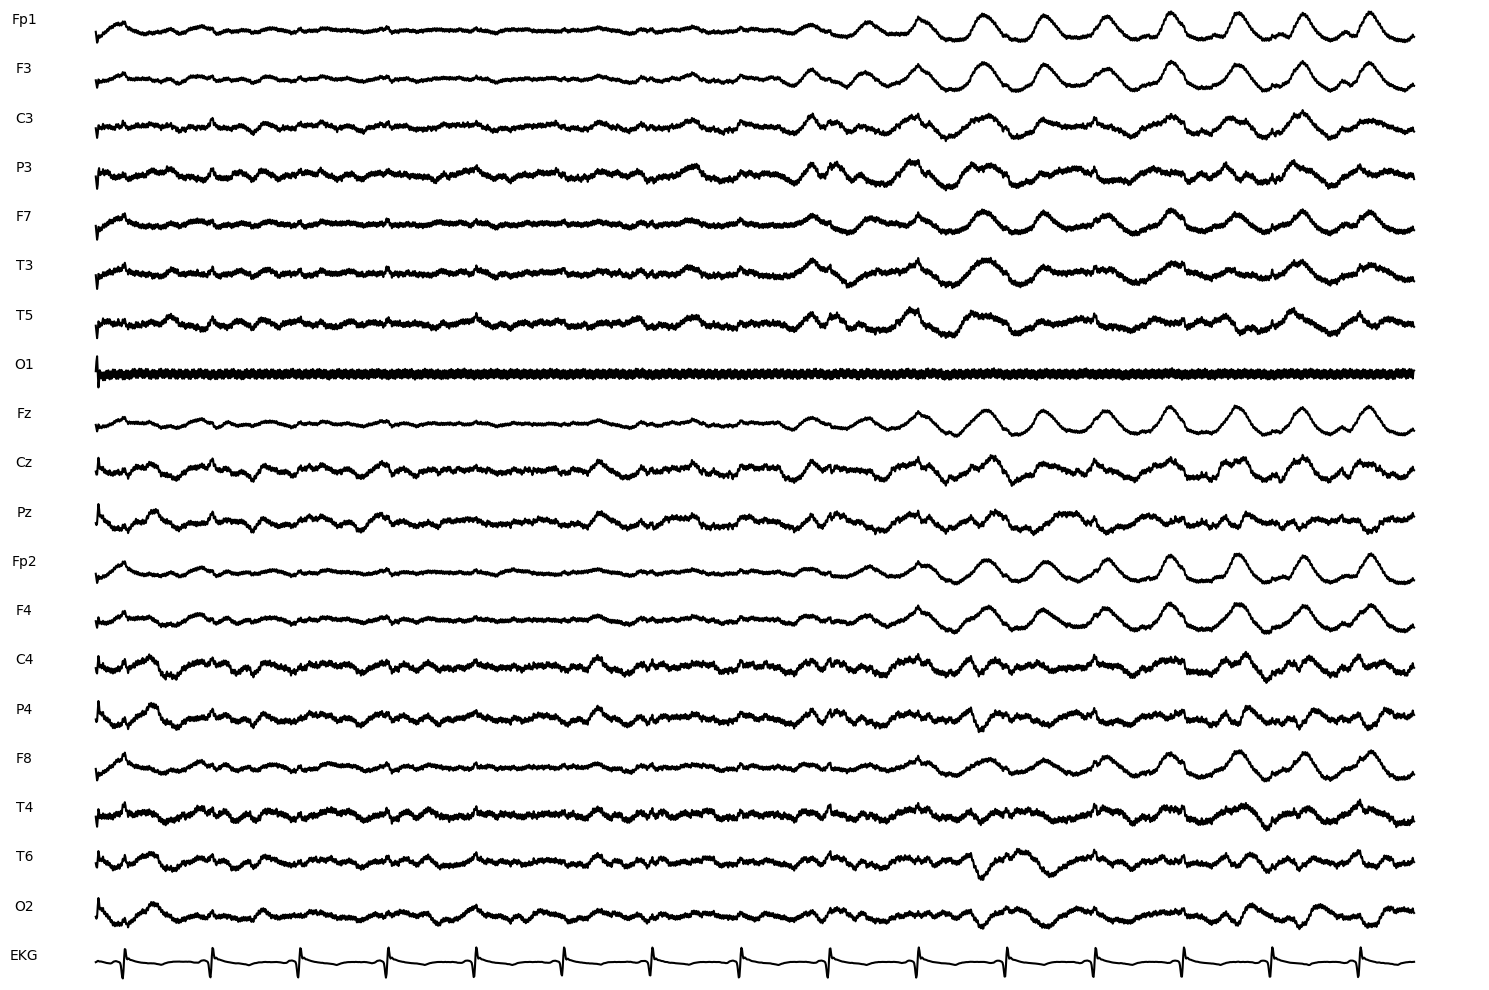

In [11]:
plot_eeg(central_window_eeg(df_eeg, 10), bp_filter=True)

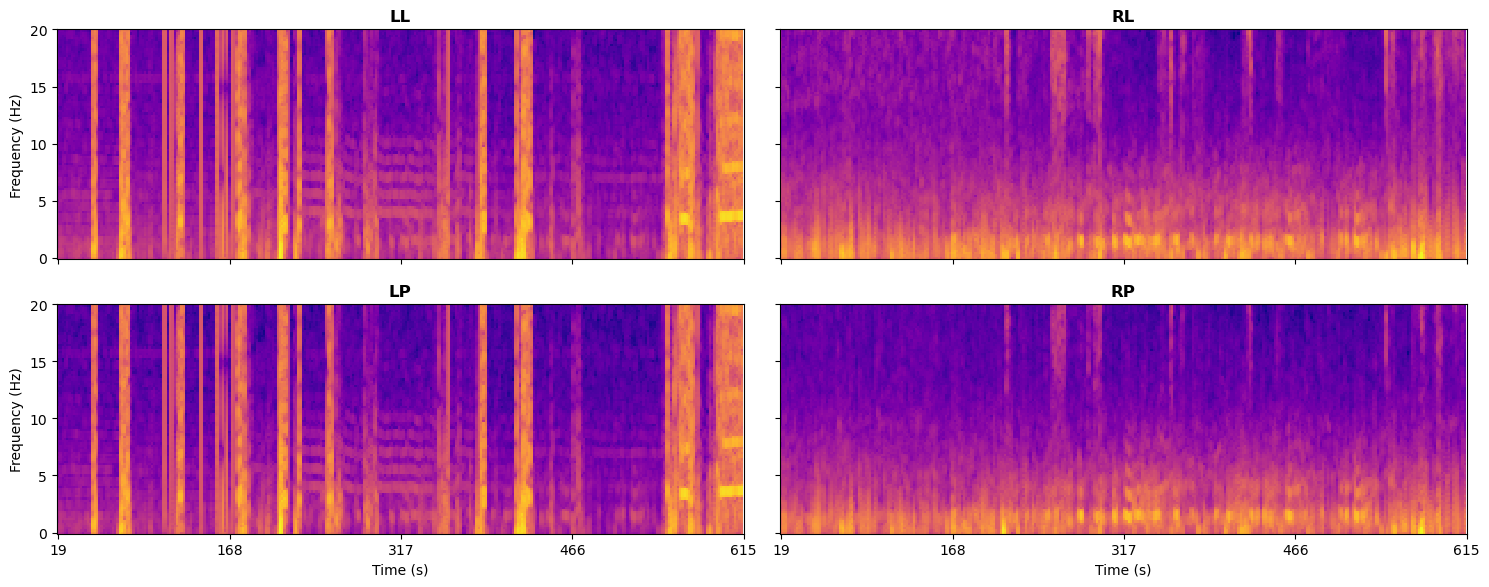

In [12]:
plot_spec(df_spec)

In [ ]:
arr_spec = df_spec.iloc[:, 1:].to_numpy().T
arr_spec.shape

In [ ]:
from torchvision.transforms import v2
from torchvision.transforms import functional as F
import torch
import random

class MyCustomTransform(torch.nn.Module):
    def __init__(self, mask_ratio=0.1, max_mask_num=2):
        super(MyCustomTransform, self).__init__()
        self.mask_ratio = mask_ratio
        self.max_mask_num = max_mask_num
    
    def forward(self, image):

        # Assuming image is a tensor of shape [C, H, W]
        _, h, w = image.shape
        
        for _ in range(random.randint(1, self.max_mask_num)):
            image = self._apply_mask(image, h, w)

        return image

    def _apply_mask(self, image, h, w):

        # Calculate max mask width and height based on mask_ratio
        max_mask_width = int(w * self.mask_ratio)
        max_mask_height = int(h * self.mask_ratio)
        
        # Randomly choose the dimension(s) to mask: 0 for cols, 1 for rows, 2 for both
        dim_to_mask = random.randint(0, 2)
        
        # Initialize mask as ones
        mask = torch.ones_like(image)
        
        # Select random start point for masking in both dimensions
        x1 = random.randint(0, w - max_mask_width)
        y1 = random.randint(0, h - max_mask_height)
        
        # Calculate end points ensuring they do not exceed max mask width/height
        x2 = x1 + random.randint(1, max_mask_width)
        y2 = y1 + random.randint(1, max_mask_height)
        
        # Adjust x2 and y2 to not go beyond image bounds
        x2 = min(x2, w)
        y2 = min(y2, h)
        
        if dim_to_mask == 0 or dim_to_mask == 2:
            mask[:, :, x1:x2] = 0
        
        if dim_to_mask == 1 or dim_to_mask == 2:
            mask[:, y1:y2, :] = 0
        
        image_new = image * mask
        
        return image_new


applier = v2.RandomApply(
    transforms=[
        v2.RandomHorizontalFlip(p=.2),
        v2.RandomVerticalFlip(p=.2),
        MyCustomTransform(mask_ratio=0.1)
        ], p=.5)


fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axs[0, 0].imshow(arr_spec, origin="lower", norm="log", cmap="plasma", interpolation="none")
axs[0, 0].set_title("Original")
for i, ax in enumerate(axs.flatten()[1:]):
    arr_spec_transformed = applier(torch.tensor(np.expand_dims(arr_spec, axis=0))).numpy()
    ax.imshow(arr_spec_transformed[0], origin="lower", norm="log", cmap="plasma", interpolation="none")
    ax.set_title(f"Transformed {i+1}")

fig.tight_layout()
plt.show()